# Lab 06 - Normal vs. Transverse Mapping Prescription
Note: Assume the Earth is sphere and the radius of the Earth is 6371 km

In [49]:
import numpy as np
import csv
import matplotlib.pyplot as plt
R=6371000 #meter

## Functions from previous lab

In [50]:
# converting ddmmss to degress
def get_degree(dd,mm,ss):
    dd= float(dd)
    mm= float(mm)
    ss=float(ss)
    degree=dd+mm/60+ss/3600
    return degree
# converting to x y z
def get_xyz(R,h,lon,lat):
    h=float(h)
    lat=np.deg2rad(get_degree(lat[0],lat[1],lat[2]))
    lon=np.deg2rad(get_degree(lon[0],lon[1],lon[2]))
    x=(R+h)*np.cos(lat)*np.cos(lon)
    y=(R+h)*np.cos(lat)*np.sin(lon)
    z=(R+h)*np.sin(lat)
    return x,y,z
def deg2xyz(R,h,lat,lon):
    lon2=np.deg2rad(lon)
    lat2=np.deg2rad(lat)
    x=(R+h)*np.cos(lat2)*np.cos(lon2)
    y=(R+h)*np.cos(lat2)*np.sin(lon2)
    z=(R+h)*np.sin(lat2)
    return x,y,z
def xyz2deg(x,y,z):
    #takes list xyz (single coord)
    r = np.sqrt(x**2 + y**2 + z**2)
    rr=np.sqrt(x**2+y**2)
    h=r-R
    lambdaa=np.arctan2(y,x)*180/np.pi
    psi=np.arctan2(z,rr)*180/np.pi
    return [h,lambdaa,psi]
def get_dms(dd):
    split_dd = math.modf(dd)
    dd= int(split_dd[1])
    mm= int(math.modf(split_dd[0] * 60)[1])
    ss= round(math.modf(split_dd[0] * 60)[0] * 60,5)
    return dd,mm,ss
def get_jocobian(lambdaa,psi,h):
    #psi=lat
    #lambda=lon
    psi=np.deg2rad(get_degree(psi[0],psi[1],psi[2]))
    lambdaa=np.deg2rad(get_degree(lambdaa[0],lambdaa[1],lambdaa[2]))
    J=np.array([
        [-(R+h)*np.cos(psi)*np.sin(lambdaa),-(R+h)*np.sin(psi)*np.cos(lambdaa),np.cos(psi)*np.cos(lambdaa)],
       [(R+h)*np.cos(psi)*np.cos(lambdaa),-(R+h)*np.sin(psi)*np.sin(lambdaa),np.cos(psi)*np.sin(lambdaa)],
      [0,(R+h)*np.cos(psi),np.sin(psi)]])
    return J


## Q1. Plot grid line, coast line, and your PoB using normal aspect. You need to provide 3 maps (PC, SF, MC) here. Use only points that are between -80° and 80° latitude for normal MC mapping.

In [51]:
poi=dict()
header=['Point_Name', 'Lon(dd)', 'Lon(mm)', 'Lon(ss)', 'Lat(dd)', 'Lat(mm)', 'Lat(ss)', 'Height (m)']
n=0
with open('poi.csv','r') as f:
    csv_reader=csv.reader(f,delimiter=',')
    for i in csv_reader:
        for j in range(8):
            if n ==0:
                poi[header[j]]=[]
            else:
                poi[header[j]].append(i[j])
        n=1
# convert ddmmss of poi into degree
poi['lon (deg)']=[]
poi['lat (deg)']=[]
for i in range(9):
    poi['lon (deg)'].append(get_degree(poi['Lon(dd)'][i],poi['Lon(mm)'][i],poi['Lon(ss)'][i]))
    poi['lat (deg)'].append(get_degree(poi['Lat(dd)'][i],poi['Lat(mm)'][i],poi['Lat(ss)'][i]))

### PC

In [91]:
# Define Xm Ym in sinusoidal mapping system
poi['Xm_pc']=[]
poi['Ym_pc']=[]
for i in range(9):
    poi['Xm_pc'].append(np.cos(np.deg2rad(poi['lat (deg)'][i]))*poi['lon (deg)'][i])
    poi['Ym_pc'].append(poi['lat (deg)'][i])
# read coastline
coastline=dict()
coastline['lon']=[]
coastline['lat']=[]
with open('coastline.dat','r') as f:
    csv_reader=csv.reader(f,delimiter='\t')
    for i in csv_reader:
        coastline['lat'].append(float(i[0].split()[1])/60)
        coastline['lon'].append(float(i[0].split()[2])/60)
coastline['Xm_pc']=coastline['lon']
coastline['Ym_pc']=coastline['lat']
grid=dict()
grid['Xm_pc']=[]
grid['Ym_pc']=[]
with open('gridline.dat','r') as f:
    csv_reader=csv.reader(f,delimiter='\t')
    for i in csv_reader:
        grid['Ym_pc'].append(float(i[0].split()[1])/60)
        grid['Xm_pc'].append(float(i[0].split()[2])/60)

### SF

In [187]:
# read coastline and convert lon/lat to Xm, Yn

coastline['Xm_sf']=np.cos(np.deg2rad(coastline['lat']))*coastline['lon']
coastline['Ym_sf']=coastline['lat']
grid['lat']=[]
grid['lon']=[]
with open('gridline.dat','r') as f:
    csv_reader=csv.reader(f,delimiter='\t')
    for i in csv_reader:
        grid['lat'].append(float(i[0].split()[1])/60)
        grid['lon'].append(float(i[0].split()[2])/60)
grid['Xm_sf']=np.cos(np.deg2rad(grid['lat']))*grid['lon']
grid['Ym_sf']=grid['lat']
# Define Xm Ym in sinusoidal mapping system
poi['Xm_sf']=[]
poi['Ym_sf']=[]
for i in range(9):
    poi['Xm_sf'].append(np.cos(np.deg2rad(poi['lat (deg)'][i]))*poi['lon (deg)'][i])
    poi['Ym_sf'].append(poi['lat (deg)'][i])

### Mercator mapping
- Xm = lambda
- Ym = ln[tan(psi/2+pi/4)]

In [206]:
from numpy import log as ln
# read coastline and convert lon/lat to Xm, Yn

coastline['Xm_m']=[]
coastline['Ym_m']=[]

coastline['Xm_m']=coastline['lon']
coastline['Ym_m']=[]
coastline['q_m']=[]
for i in range(len(coastline['lat'])):
    angle_temp=np.deg2rad(coastline['lat'][i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    coastline['Ym_m'].append(Ymm)
    coastline['q_m'].append(np.rad2deg(Ymm))
# Grid
grid['Xm_m']=grid['lon']
grid['Ym_m']=[]
grid['qm_m']=[]
for i in range(len(grid['lat'])):
    angle_temp=np.deg2rad(grid['lat'][i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    grid['Ym_m'].append(Ymm)
    grid['q_m'].append(np.rad2deg(Ymm))

# compute Xm Ym for poi
poi['Xm_m']=poi['lon (deg)']
poi['Ym_m']=[]
for i in range(9):
    angle_temp=np.deg2rad(poi['lat (deg)'][i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    poi['Ym_m'].append(Ymm)

<ipython-input-206-c2fbc437571c>:20: RuntimeWarning: divide by zero encountered in log
  Ymm=ln(np.tan(angle_temp+np.pi/4))


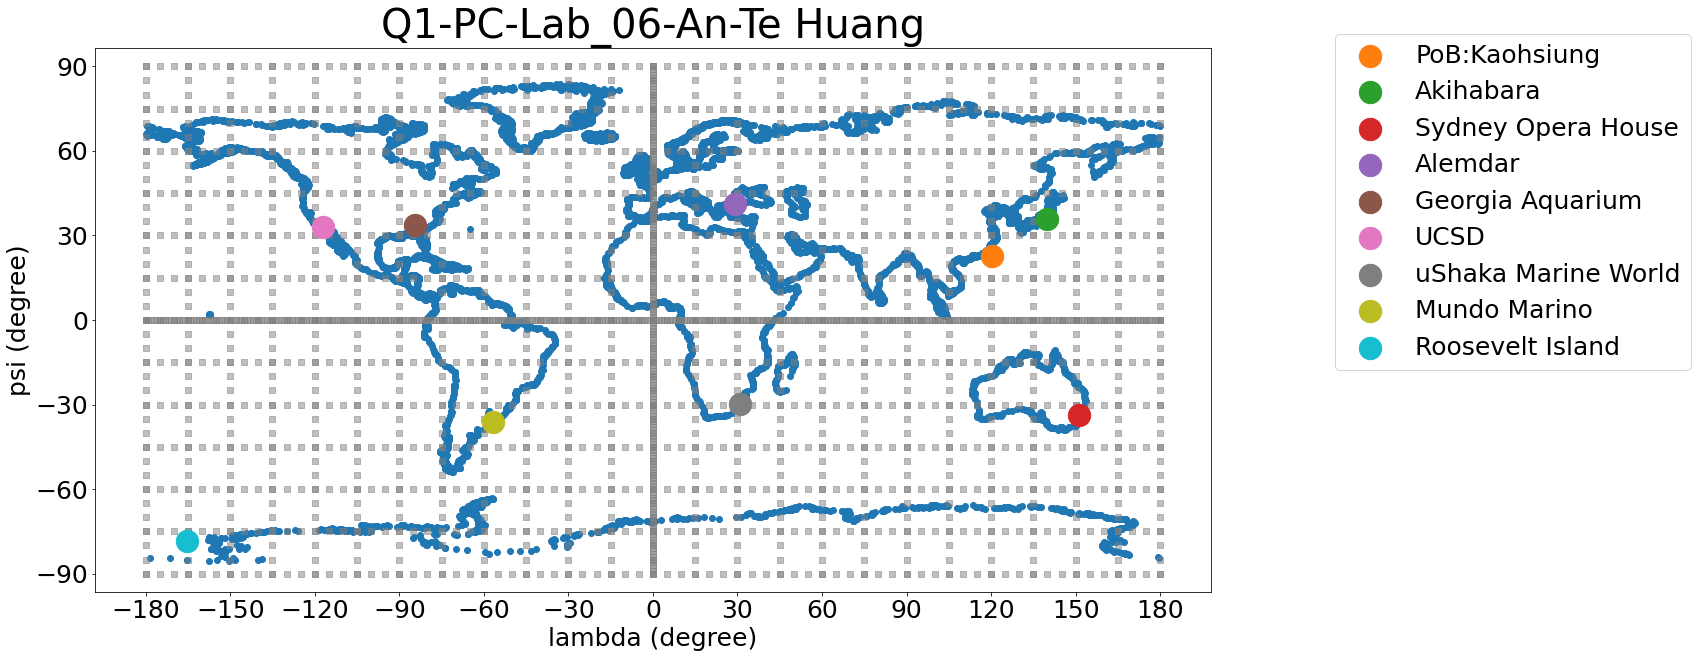

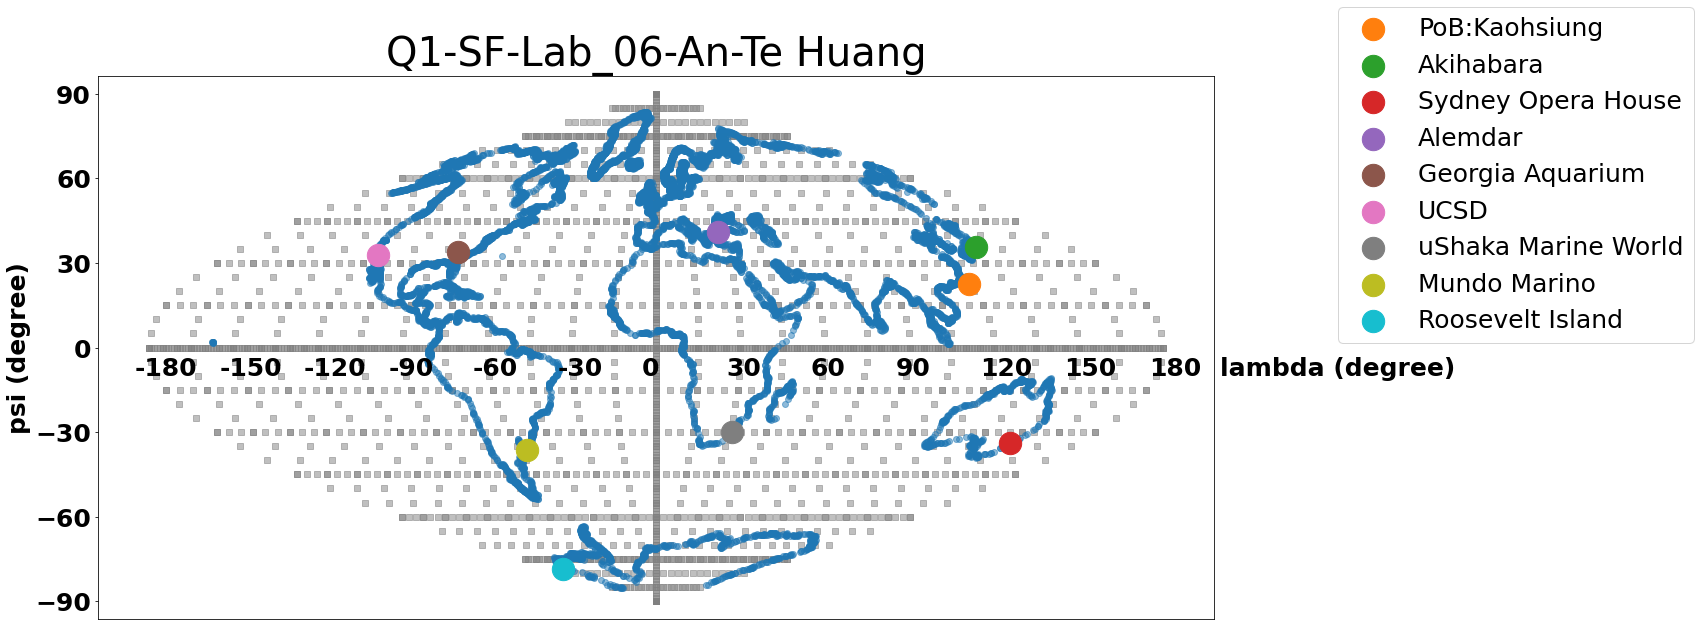

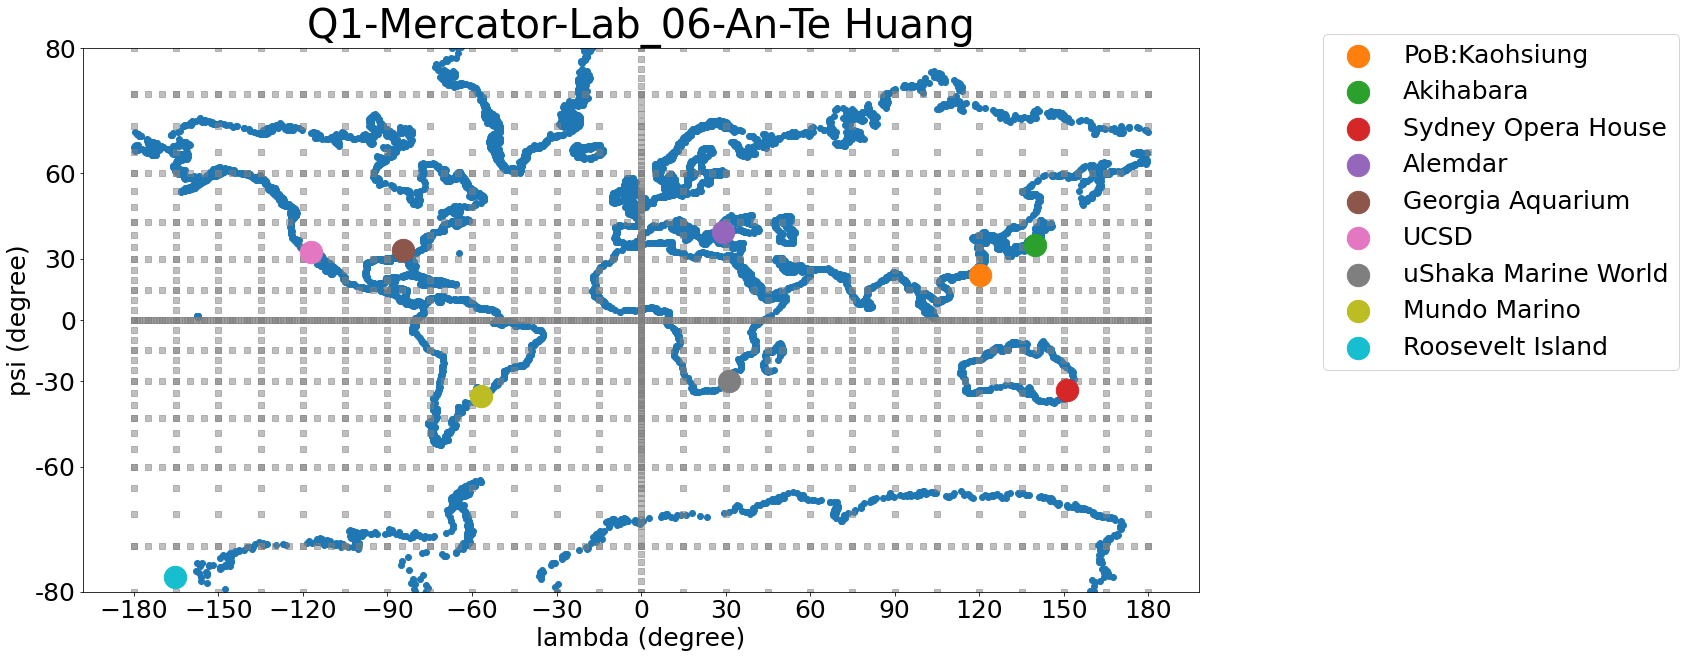

In [65]:

# plot Plate Carree
f1=plt.figure(figsize=(20,10))
plt.axis('equal')
plt.title('Q1-PC-Lab_06-An-Te Huang',fontsize=40)
plt.xlabel('lambda (degree)',fontsize=25)
plt.yticks([-90,-60,-30,0,30,60,90],fontsize=25)
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180],fontsize=25)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['lon'],coastline['lat'])
plt.scatter(grid['Xm_pc'],grid['Ym_pc'],marker=',',color='gray',alpha=0.5)
for i in range(9):
    plt.scatter(poi['lon (deg)'][i],poi['lat (deg)'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.05],fontsize=25)
plt.show()

## plot SF
f2=plt.figure(figsize=(20,10))
plt.axis('equal')
plt.title('Q1-SF-Lab_06-An-Te Huang',fontsize=40)
# plt.xlabel('lambda (degree)',fontsize=25)
plt.xticks([])
Xw=[-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
Yw=[0 for i in range(len(Xw))]
for i in range(len(Xw)):
               plt.text(Xw[i]-5,Yw[i]-10,int(Xw[i]), fontsize=25,fontweight='bold')
plt.text(200,-10,'lambda (degree)', fontsize=25,fontweight='bold')
plt.yticks([-90,-60,-30,0,30,60,90],fontsize=25,fontweight='bold')
plt.ylabel('psi (degree)',fontsize=25,fontweight='bold')
plt.scatter(grid['Xm_sf'],grid['Ym_sf'],marker=',',color='gray',alpha=0.5)
plt.scatter(coastline['Xm_sf'],coastline['Ym_sf'], alpha=0.5)
for i in range(9):
    plt.scatter(poi['Xm_sf'][i],poi['Ym_sf'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.15],fontsize=25)
plt.show()
# M
#compute q when psi =-80 and 80
ql=ln(np.tan(np.deg2rad(-80)/2+np.pi/4))
qt=ln(np.tan(np.deg2rad(80)/2+np.pi/4))
yticks=[-80,-60,-30,0,30,60,80]
labels=(-80,-60,-30,0,30,60,80)
qticks=[]
for i in range(7):
    angle_temp=np.deg2rad(yticks[i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    qticks.append(Ymm)
f3=plt.figure(figsize=(20,10))
# plt.axis('equal')
plt.title('Q1-Mercator-Lab_06-An-Te Huang',fontsize=40)
plt.ylim(ql,qt)
plt.rcParams['figure.figsize'] = [15, 18]

plt.xlabel('lambda (degree)',fontsize=25)
plt.yticks(qticks,labels,fontsize=25)
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180],fontsize=25)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['Xm_m'],coastline['Ym_m'])
plt.scatter(grid['Xm_m'],grid['Ym_m'],marker=',',color='gray',alpha=0.5)
for i in range(9):
    plt.scatter(poi['Xm_m'][i],poi['Ym_m'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.05],fontsize=25)
plt.show()

## Q2 Describe in detail the mathematics you used to “make” your PoB meridian to the new equator.
$\begin{bmatrix} x'\\y'\\z'\end{bmatrix}=R_2(\lambda) R_1(\pi/2)\ \begin{bmatrix} x\\y\\z\end{bmatrix}$    
where x',y',z' are the coordinates after transformation;    
$R_2(\lambda)=\begin{bmatrix} \cos(\lambda)&0&-\sin(\lambda)\\0&1&0\\\sin(\lambda)&0&\cos(\lambda)\end{bmatrix}$;
$R_1(\pi/2)=\begin{bmatrix} 1&0&0\\0&\cos(\pi/2)&\sin(\pi/2)\\0&-\sin(\pi/2)&\cos(\pi/2)\end{bmatrix}=\begin{bmatrix} 1&0&0\\0&0&1\\0&-1&0\end{bmatrix}$;    
    x,y,z are the coordinates before transformation


## Q3 Plot grid line, coast line, and your PoB using transverse aspect. You need to provide another 3 maps (PC, SF, M) here. Use only points that are between -80° and 80° latitude (after the transformation) for transverse MC mapping.
- z is not used in mapping
- Workflow: convert $\lambda,\psi, height$ to xyz -> convert xyz to x'y'z'-> convert x'y'z' to $\lambda',\psi',height'$-> convert $\lambda',\psi',height'$ to mapping

### Convert x,y,z to x',y',z' , *assuming the height for coastline and grid is 0*

In [72]:
# Get xyz for poi
poi['x']=[]
poi['y']=[]
poi['z']=[]
for i in range(9):
    poi['x'].append(deg2xyz(R,float(poi['Height (m)'][i]),poi['lat (deg)'][i],poi['lon (deg)'][i])[0])
    poi['y'].append(deg2xyz(R,float(poi['Height (m)'][i]),poi['lat (deg)'][i],poi['lon (deg)'][i])[1])
    poi['z'].append(deg2xyz(R,float(poi['Height (m)'][i]),poi['lat (deg)'][i],poi['lon (deg)'][i])[2])
# Get xyz for coastline and grid
coastline['x']=[]
coastline['y']=[]
coastline['z']=[]
for i in range(len(coastline['lon'])):
    coastline['x'].append(deg2xyz(R,0,coastline['lat'][i],coastline['lon'][i])[0])
    coastline['y'].append(deg2xyz(R,0,coastline['lat'][i],coastline['lon'][i])[1])
    coastline['z'].append(deg2xyz(R,0,coastline['lat'][i],coastline['lon'][i])[2])
# Get xyz for grid line

grid['x']=[]
grid['y']=[]
grid['z']=[]
for i in range(len(grid['lon'])):
    grid['x'].append(deg2xyz(R,0,grid['lat'][i],grid['lon'][i])[0])
    grid['y'].append(deg2xyz(R,0,grid['lat'][i],grid['lon'][i])[1])
    grid['z'].append(deg2xyz(R,0,grid['lat'][i],grid['lon'][i])[2])

In [73]:
def transverse(lambdaa,x,y,z):
    lambdaa=np.deg2rad(lambdaa)
    R1=np.array([[1,0,0],[0,0,1],[0,-1,0]])
    R2=np.array([[np.cos(lambdaa),0,-np.sin(lambdaa)],[0,1,0],[np.sin(lambdaa),0,np.cos(lambdaa)]])
    R3=np.array([[np.cos(lambdaa),np.sin(lambdaa),0],[0,0,1],[np.sin(lambdaa),-np.cos(lambdaa),0]])
    m=np.array([[x],[y],[z]])
#     t=[[np.cos(lambdaa)*x+np.sin(lambdaa)*y],[z],[np.sin(lambdaa)*x-np.cos(lambdaa)*y]]
    t=R3.dot(m)
#     t=R2.dot(R1).dot(m)
    return t
# get x',y',z' for poi
poi['x2']=[]
poi['y2']=[]
poi['z2']=[]
for i in range(9):
    poi['x2'].append(transverse(poi['lon (deg)'][0],poi['x'][i],poi['y'][i],poi['z'][i])[0][0])
    poi['y2'].append(transverse(poi['lon (deg)'][0],poi['x'][i],poi['y'][i],poi['z'][i])[1][0])
    poi['z2'].append(transverse(poi['lon (deg)'][0],poi['x'][i],poi['y'][i],poi['z'][i])[2][0])
# get x',y',z' for coastline
coastline['x2']=[]
coastline['y2']=[]
coastline['z2']=[]
for i in range(len(coastline['x'])):
    coastline['x2'].append(transverse(poi['lon (deg)'][0],coastline['x'][i],coastline['y'][i],coastline['z'][i])[0][0])
    coastline['y2'].append(transverse(poi['lon (deg)'][0],coastline['x'][i],coastline['y'][i],coastline['z'][i])[1][0])
    coastline['z2'].append(transverse(poi['lon (deg)'][0],coastline['x'][i],coastline['y'][i],coastline['z'][i])[2][0])

# get x',y',z' for grid line
grid['x2']=[]
grid['y2']=[]
grid['z2']=[]
for i in range(len(grid['x'])):
    grid['x2'].append(transverse(poi['lon (deg)'][0],grid['x'][i],grid['y'][i],grid['z'][i])[0][0])
    grid['y2'].append(transverse(poi['lon (deg)'][0],grid['x'][i],grid['y'][i],grid['z'][i])[1][0])
    grid['z2'].append(transverse(poi['lon (deg)'][0],grid['x'][i],grid['y'][i],grid['z'][i])[2][0])

In [74]:
print(poi['lon (deg)'])

[120.3561111111111, 139.7752777777778, 151.21499999999997, 28.97833333333333, -84.39055555555557, -117.23388888888888, 31.045555555555556, -56.749722222222225, -165.42083333333332]


In [75]:
# get lambda', psi', h' for poi
poi['lambda2']=[]
poi['psi2']=[]
poi['h2']=[]
for i in range(9):
    poi['h2'].append(xyz2deg(poi['x2'][i],poi['y2'][i],poi['z2'][i])[0])
    poi['lambda2'].append(xyz2deg(poi['x2'][i],poi['y2'][i],poi['z2'][i])[1])
    poi['psi2'].append(xyz2deg(poi['x2'][i],poi['y2'][i],poi['z2'][i])[2])
# get lambda', psi', h' for coastline
coastline['lambda2']=[]
coastline['psi2']=[]
coastline['h2']=[]
for i in range(len(coastline['x2'])):
    coastline['h2'].append(xyz2deg(coastline['x2'][i],coastline['y2'][i],coastline['z2'][i])[0])
    coastline['lambda2'].append(xyz2deg(coastline['x2'][i],coastline['y2'][i],coastline['z2'][i])[1])
    coastline['psi2'].append(xyz2deg(coastline['x2'][i],coastline['y2'][i],coastline['z2'][i])[2])
# get lambda', psi', h' for grid
grid['lambda2']=[]
grid['psi2']=[]
grid['h2']=[]
for i in range(len(grid['x2'])):
    grid['h2'].append(xyz2deg(grid['x2'][i],grid['y2'][i],grid['z2'][i])[0])
    grid['lambda2'].append(xyz2deg(grid['x2'][i],grid['y2'][i],grid['z2'][i])[1])
    grid['psi2'].append(xyz2deg(grid['x2'][i],grid['y2'][i],grid['z2'][i])[2])

Now, I will start mapping.
### Transversed PC

In [76]:
# Define Xm Ym in PC mapping system
poi['Xm_tpc']=poi['lambda2']
poi['Ym_tpc']=poi['psi2']

coastline['Xm_tpc']=coastline['lambda2']
coastline['Ym_tpc']=coastline['psi2']

grid['Xm_tpc']=grid['lambda2']
grid['Ym_tpc']=grid['psi2']

### Transversed SF

In [77]:
# Define Xm Ym in SF mapping system
poi['Xm_tsf']=np.cos(np.deg2rad(poi['psi2']))*poi['lambda2']
poi['Ym_tsf']=poi['psi2']

coastline['Xm_tsf']=np.cos(np.deg2rad(coastline['psi2']))*coastline['lambda2']
coastline['Ym_tsf']=coastline['psi2']

grid['Xm_tsf']=np.cos(np.deg2rad(grid['psi2']))*grid['lambda2']
grid['Ym_tsf']=grid['psi2']

### Transversed Mercator

In [78]:
# Define Xm Ym in mercator mapping system
poi['Xm_tm']=poi['lambda2']
poi['Ym_tm']=[]
for i in range(len(poi['psi2'])):
    angle_temp=np.deg2rad(poi['psi2'][i])/2
    Ymm=np.rad2deg(ln(np.tan(angle_temp+np.pi/4)))
    poi['Ym_tm'].append(Ymm)

coastline['Xm_tm']=coastline['lambda2']
coastline['Ym_tm']=[]
for i in range(len(coastline['psi2'])):
    angle_temp=np.deg2rad(coastline['psi2'][i])/2
    Ymm=np.rad2deg(ln(np.tan(angle_temp+np.pi/4)))
    coastline['Ym_tm'].append(Ymm)    

grid['Xm_tm']=grid['lambda2']
grid['Ym_tm']=[]
for i in range(len(grid['psi2'])):
    angle_temp=np.deg2rad(grid['psi2'][i])/2
    Ymm=np.rad2deg(ln(np.tan(angle_temp+np.pi/4)))
    grid['Ym_tm'].append(Ymm)        

use plt.ylim() to set min y and max y to -80~80


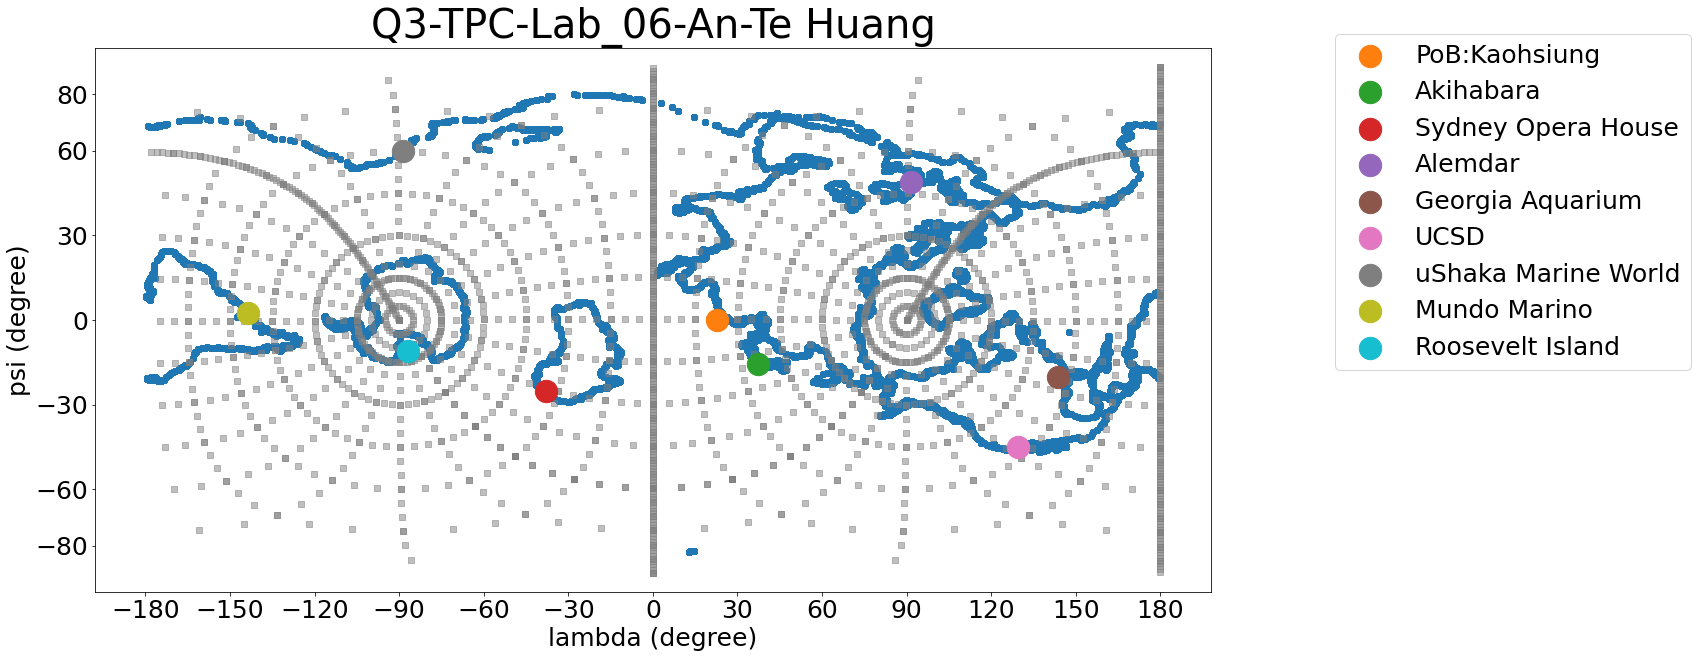

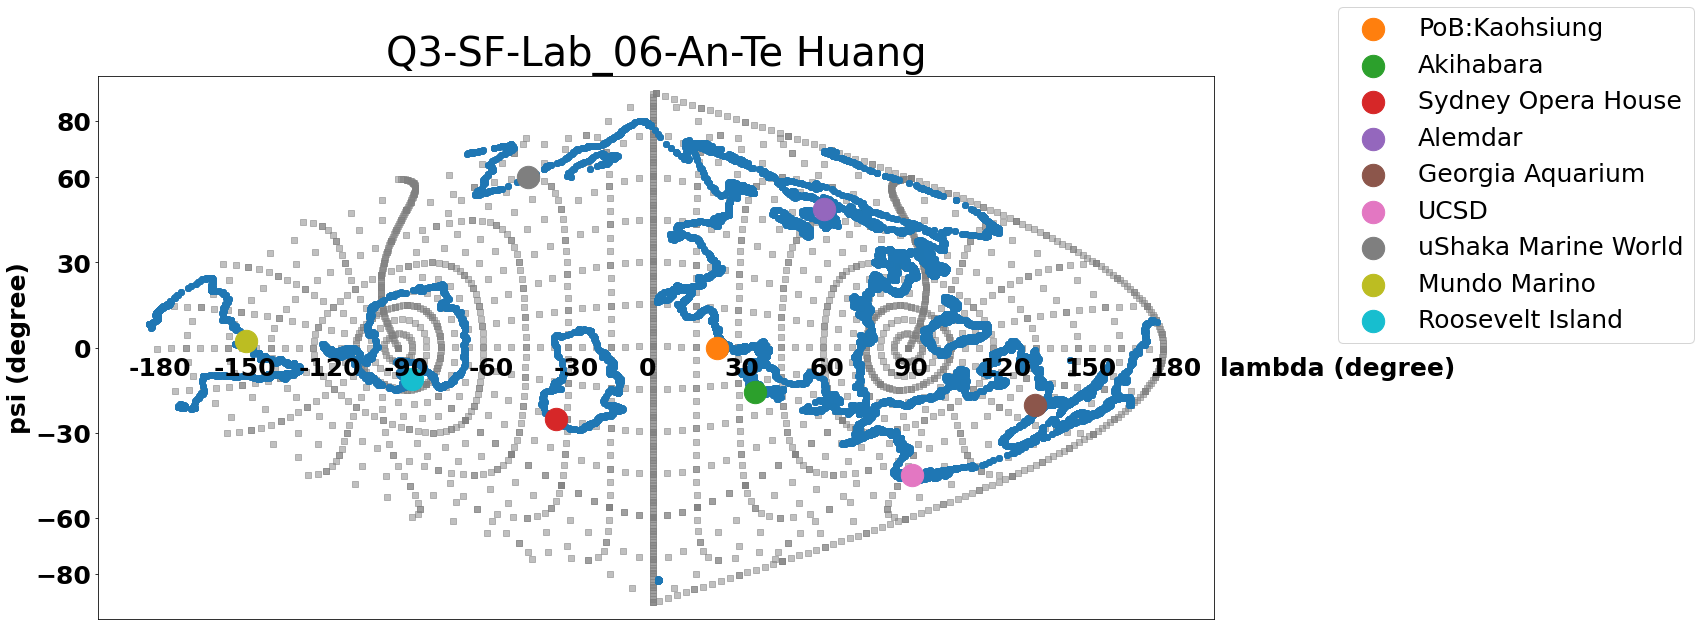

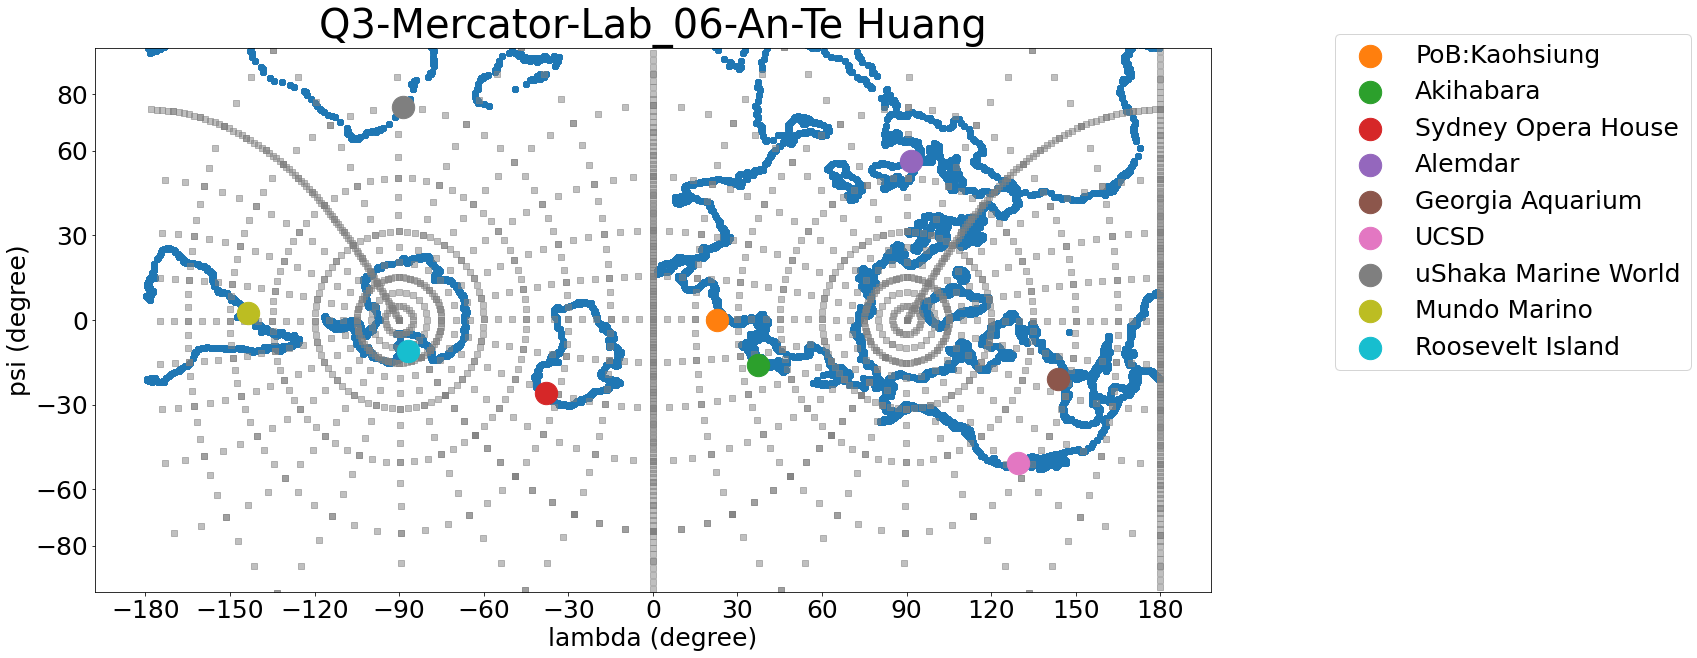

In [79]:
print('use plt.ylim() to set min y and max y to -80~80')
# plot Plate Carree
f1=plt.figure(figsize=(20,10))
plt.title('Q3-TPC-Lab_06-An-Te Huang',fontsize=40)
plt.xlabel('lambda (degree)',fontsize=25)
plt.yticks([-80,-60,-30,0,30,60,80],fontsize=25)
plt.ylim(-80,80)
plt.axis('equal')

plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180],fontsize=25)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['Xm_tpc'],coastline['Ym_tpc'])
plt.scatter(grid['Xm_tpc'],grid['Ym_tpc'],marker=',',color='gray',alpha=0.5)
for i in range(9):
    plt.scatter(poi['Xm_tpc'][i],poi['Ym_tpc'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.05],fontsize=25)
plt.show()

## plot SF
f2=plt.figure(figsize=(20,10))
plt.axis('equal')
plt.title('Q3-SF-Lab_06-An-Te Huang',fontsize=40)
# plt.xlabel('lambda (degree)',fontsize=25)
plt.xticks([])
Xw=[-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
Yw=[0 for i in range(len(Xw))]
for i in range(len(Xw)):
               plt.text(Xw[i]-5,Yw[i]-10,int(Xw[i]), fontsize=25,fontweight='bold')
plt.text(200,-10,'lambda (degree)', fontsize=25,fontweight='bold')
plt.yticks([-80,-60,-30,0,30,60,80],fontsize=25,fontweight='bold')
plt.ylim(-80,80)
plt.ylabel('psi (degree)',fontsize=25,fontweight='bold')
plt.scatter(grid['Xm_tsf'],grid['Ym_tsf'],marker=',',color='gray',alpha=0.5)
plt.scatter(coastline['Xm_tsf'],coastline['Ym_tsf'], alpha=0.5)
for i in range(9):
    plt.scatter(poi['Xm_tsf'][i],poi['Ym_tsf'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.15],fontsize=25)
plt.show()
# M
#compute q when psi =-80 and 80
ql=ln(np.tan(np.deg2rad(-80)/2+np.pi/4))
qt=ln(np.tan(np.deg2rad(80)/2+np.pi/4))
yticks=[-80,-60,-30,0,30,60,80]
# labels=(-80,-60,-30,0,30,60,80)
qticks=[]
# for i in range(7):
#     angle_temp=np.deg2rad(yticks[i])/2
#     Ymm=ln(np.tan(angle_temp+np.pi/4))
#     qticks.append(Ymm)
f3=plt.figure(figsize=(20,10))
plt.axis('equal')
plt.title('Q3-Mercator-Lab_06-An-Te Huang',fontsize=40)
plt.ylim(-80,80)
# plt.rcParams['figure.figsize'] = [15, 18]

plt.xlabel('lambda (degree)',fontsize=25)
plt.yticks(yticks,fontsize=25)
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180],fontsize=25)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['Xm_tm'],coastline['Ym_tm'])
plt.scatter(grid['Xm_tm'],grid['Ym_tm'],marker=',',color='gray',alpha=0.5)
for i in range(9):
    plt.scatter(poi['Xm_tm'][i],poi['Ym_tm'][i],label=poi['Point_Name'][i],s=500)
plt.legend(bbox_to_anchor=[1.1,1.05],fontsize=25)
plt.show()

## Q4 For all maps (3 normal and 3 transverse), select a 15°x15° “square” ABCD that contains your POB. 
- Use three lines: EW(AB), NS(AD), NE(AC), e.g. between two “grid” points forming the intersections between meridians and parallel circles. 
- Calculate the scales (NS, NE, EW direction) (representative fraction, e.g. 1:2,000,000) of all maps. Show your measurements in the map, and report in your discussion, too. 
- Calculate the real world distances and the scales inside your code.
- A: lambda=120, psi=15
- B: lambda=135, psi=15
- C: lambda=135, psi=30
- D: lambda=120, psi=30
- **For the scale on the map, assuming one degree is 0.01 m**
- Assuming h for ABCD =0

### Real world

In [80]:
# Calculating distance in real world
# dAB=Rcos(psi)dlambda
dAB=R*np.cos(np.deg2rad(15))*np.deg2rad(15)*100 #cm
# dCD
dCD=R*np.cos(np.deg2rad(30))*np.deg2rad(15)*100 #cm
#dBC=dAD=Rdpsi
dAD=R*np.deg2rad(15)*100 #cm
dBC=dAD
#dAC=(dAB^2+dBC^2)^0.5, dBC=dAD
dAC=np.sqrt(dAB**2+dAD**2)

### Normal

In [81]:
# PC
dABm_pc=15 #cm
sAB_pc=dAB/dABm_pc
dBCm_pc=15
sBC_pc=dBC/dBCm_pc
dCDm_pc=15
sCD_pc=dCD/dCDm_pc
dADm_pc=15
sAD_pc=dAD/dADm_pc
dACm_pc=np.sqrt(2*15**2)
sAC_pc=dAC/dACm_pc

In [82]:
# SF
Xa=np.cos(np.deg2rad(20))*120 #degree
Xb=np.cos(np.deg2rad(20))*135
Xc=np.cos(np.deg2rad(35))*135
Xd=np.cos(np.deg2rad(35))*120
Ya=15
Yb=15
Yc=30
Yd=30
def get_distance(x1,x2,y1,y2):
    d=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d
# get the distance in mapping world in meter (assuming 1 degree = 1cm)
dABm_sf=get_distance(Xa,Xb,Ya,Yb) 
dBCm_sf=get_distance(Xb,Xc,Yb,Yc)
dCDm_sf=get_distance(Xc,Xd,Yc,Yd)
dADm_sf=get_distance(Xa,Xd,Ya,Yd)
dACm_sf=get_distance(Xa,Xc,Ya,Yc)
sAB_sf=dAB/dABm_sf
sBC_sf=dBC/dBCm_sf
sCD_sf=dCD/dCDm_sf
sAD_sf=dAD/dADm_sf
sAC_sf=dAC/dACm_sf

In [83]:
# Mercator
ABCD=dict()
ABCD['lambda']=[120,135,135,120]
ABCD['psi']=[15,15,30,30]
Xa=120
Xb=135
Xc=135
Xd=120
angle_temp=np.deg2rad(15)/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Ya=np.rad2deg(Ymm)
Yb=Ya
angle_temp=np.deg2rad(30)/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Yc=np.rad2deg(Ymm)
Yc=Yd
dABm_m=get_distance(Xa,Xb,Ya,Yb) 
dBCm_m=get_distance(Xb,Xc,Yb,Yc)
dCDm_m=get_distance(Xc,Xd,Yc,Yd)
dADm_m=get_distance(Xa,Xd,Ya,Yd)
dACm_m=get_distance(Xa,Xc,Ya,Yc)
sAB_m=dAB/dABm_m
sBC_m=dBC/dBCm_m
sCD_m=dCD/dCDm_m
sAD_m=dAD/dADm_m
sAC_m=dAC/dACm_m

### Transversed

In [84]:
#get xyz of ABCD

ABCD['x']=[]
ABCD['y']=[]
ABCD['z']=[]
for i in range(4):
    ABCD['x'].append(deg2xyz(R,0,ABCD['psi'][i],ABCD['lambda'][i])[0])
    ABCD['y'].append(deg2xyz(R,0,ABCD['psi'][i],ABCD['lambda'][i])[1])
    ABCD['z'].append(deg2xyz(R,0,ABCD['psi'][i],ABCD['lambda'][i])[2])
# get x',y',z' of ABCD
ABCD['x2']=[]
ABCD['y2']=[]
ABCD['z2']=[]
for i in range(4):
    ABCD['x2'].append(transverse(poi['lon (deg)'][i],ABCD['x'][i],ABCD['y'][i],ABCD['z'][i])[0][0])
    ABCD['y2'].append(transverse(poi['lon (deg)'][i],ABCD['x'][i],ABCD['y'][i],ABCD['z'][i])[1][0])
    ABCD['z2'].append(transverse(poi['lon (deg)'][i],ABCD['x'][i],ABCD['y'][i],ABCD['z'][i])[2][0])
# get lambda',psi',h'
ABCD['lambda2']=[]
ABCD['psi2']=[]
ABCD['h2']=[]
for i in range(4):
    ABCD['h2'].append(xyz2deg(ABCD['x2'][i],ABCD['y2'][i],ABCD['z2'][i])[0])
    ABCD['lambda2'].append(xyz2deg(ABCD['x2'][i],ABCD['y2'][i],ABCD['z2'][i])[1])
    ABCD['psi2'].append(xyz2deg(ABCD['x2'][i],ABCD['y2'][i],ABCD['z2'][i])[2])


In [210]:
# TPC
Xa=ABCD['lambda2'][0]
Xb=ABCD['lambda2'][1]
Xc=ABCD['lambda2'][2]
Xd=ABCD['lambda2'][3]
Ya=ABCD['psi2'][0]
Yb=ABCD['psi2'][1]
Yc=ABCD['psi2'][2]
Yd=ABCD['psi2'][3]
dABm_tpc=get_distance(Xa,Xb,Ya,Yb) 
dBCm_tpc=get_distance(Xb,Xc,Yb,Yc)
dCDm_tpc=get_distance(Xc,Xd,Yc,Yd)
dADm_tpc=get_distance(Xa,Xd,Ya,Yd)
dACm_tpc=get_distance(Xa,Xc,Ya,Yc)
sAB_tpc=dAB/dABm_tpc
sBC_tpc=dBC/dBCm_tpc
sCD_tpc=dCD/dCDm_tpc
sAD_tpc=dAD/dADm_tpc
sAC_tpc=dAC/dACm_tpc


-0.04960510708565913
-60.751761046167545


In [86]:
#TSF
Xa=np.cos(np.deg2rad(ABCD['psi2'][0]))*ABCD['lambda2'][0] #degree
Xb=np.cos(np.deg2rad(ABCD['psi2'][1]))*ABCD['lambda2'][1]
Xc=np.cos(np.deg2rad(ABCD['psi2'][2]))*ABCD['lambda2'][2]
Xd=np.cos(np.deg2rad(ABCD['psi2'][3]))*ABCD['lambda2'][3]
Ya=ABCD['psi2'][0]
Yb=ABCD['psi2'][1]
Yc=ABCD['psi2'][2]
Yd=ABCD['psi2'][3]
dABm_tsf=get_distance(Xa,Xb,Ya,Yb) 
dBCm_tsf=get_distance(Xb,Xc,Yb,Yc)
dCDm_tsf=get_distance(Xc,Xd,Yc,Yd)
dADm_tsf=get_distance(Xa,Xd,Ya,Yd)
dACm_tsf=get_distance(Xa,Xc,Ya,Yc)
sAB_tsf=dAB/dABm_tsf
sBC_tsf=dBC/dBCm_tsf
sCD_tsf=dCD/dCDm_tsf
sAD_tsf=dAD/dADm_tsf
sAC_tsf=dAC/dACm_tsf

In [87]:
#TM
Xa=ABCD['lambda2'][0]
Xb=ABCD['lambda2'][1]
Xc=ABCD['lambda2'][2]
Xd=ABCD['lambda2'][3]
angle_temp=np.deg2rad(ABCD['psi2'][0])/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Ya=np.rad2deg(Ymm)
angle_temp=np.deg2rad(ABCD['psi2'][1])/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Yb=np.rad2deg(Ymm)
angle_temp=np.deg2rad(ABCD['psi2'][2])/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Yc=np.rad2deg(Ymm)
angle_temp=np.deg2rad(ABCD['psi2'][3])/2
Ymm=ln(np.tan(angle_temp+np.pi/4))
Yd=np.rad2deg(Ymm)
dABm_tm=get_distance(Xa,Xb,Ya,Yb) 
dBCm_tm=get_distance(Xb,Xc,Yb,Yc)
dCDm_tm=get_distance(Xc,Xd,Yc,Yd)
dADm_tm=get_distance(Xa,Xd,Ya,Yd)
dACm_tm=get_distance(Xa,Xc,Ya,Yc)
sAB_tm=dAB/dABm_tm
sBC_tm=dBC/dBCm_tm
sCD_tm=dCD/dCDm_tm
sAD_tm=dAD/dADm_tm
sAC_tm=dAC/dACm_tm

In [88]:
print('Plate Carree:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_pc+'|'+'1:%15.15f'%sAB_pc)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_pc+'|'+'1:%15.15f'%sAD_pc)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_pc+'|'+'1:%15.15f'%sBC_pc)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_pc+'|'+'1:%15.15f'%sCD_pc)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_pc+'|'+'1:%15.15f'%sAC_pc)
print()
print('Sanson-Flamsteed:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_sf+'|'+'1:%15.15f'%sAB_sf)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_sf+'|'+'1:%15.15f'%sAD_sf)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_sf+'|'+'1:%15.15f'%sBC_sf)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_sf+'|'+'1:%15.15f'%sCD_sf)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_sf+'|'+'1:%15.15f'%sAC_sf)
print()
print('Mercator mapping:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_m+'|'+'1:%15.15f'%sAB_m)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_m+'|'+'1:%15.15f'%sAD_m)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_m+'|'+'1:%15.15f'%sBC_m)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_m+'|'+'1:%15.15f'%sCD_m)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_m+'|'+'1:%15.15f'%sAC_m)
print()
print('Transversed Plate Carree:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_tpc+'|'+'1:%15.15f'%sAB_tpc)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_tpc+'|'+'1:%15.15f'%sAD_tpc)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_tpc+'|'+'1:%15.15f'%sBC_tpc)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_tpc+'|'+'1:%15.15f'%sCD_tpc)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_tpc+'|'+'1:%15.15f'%sAC_tpc)
print()
print('Transversed Sanson-Flamsteed:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_tsf+'|'+'1:%15.15f'%sAB_tsf)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_tsf+'|'+'1:%15.15f'%sAD_tsf)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_tsf+'|'+'1:%15.15f'%sBC_tsf)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_tsf+'|'+'1:%15.15f'%sCD_tsf)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_tsf+'|'+'1:%15.15f'%sAC_tsf)
print()
print('Transversed Mercator:')
print('%15s'%'section'+'|'+'%20s'%'distance in RW (cm)'+'|'+'%20s'%'distance in MW (cm)'+'|'+'%15s'%'scale (MW:RW)')
print('----------------------------------------------------------------------------------')
print('%15s'%'AB'+'|'+'%20.1f'%dAB+'|'+'%20.1f'%dABm_tm+'|'+'1:%15.15f'%sAB_tm)
print('%15s'%'AD'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dADm_tm+'|'+'1:%15.15f'%sAD_tm)
print('%15s'%'BC'+'|'+'%20.1f'%dAD+'|'+'%20.1f'%dBCm_tm+'|'+'1:%15.15f'%sBC_tm)
print('%15s'%'CD'+'|'+'%20.1f'%dCD+'|'+'%20.1f'%dCDm_tm+'|'+'1:%15.15f'%sCD_tm)
print('%15s'%'AC'+'|'+'%20.1f'%dAC+'|'+'%20.1f'%dACm_tm+'|'+'1:%15.15f'%sAC_tm)

Plate Carree:
        section| distance in RW (cm)| distance in MW (cm)|  scale (MW:RW)
----------------------------------------------------------------------------------
             AB|         161109077.1|                15.0|1:10740605.139829773455858
             AD|         166792390.0|                15.0|1:11119492.664455872029066
             BC|         166792390.0|                15.0|1:11119492.664455872029066
             CD|         144446446.9|                15.0|1:9629763.124613501131535
             AC|         231896175.2|                21.2|1:10931690.534510793164372

Sanson-Flamsteed:
        section| distance in RW (cm)| distance in MW (cm)|  scale (MW:RW)
----------------------------------------------------------------------------------
             AB|         161109077.1|                14.1|1:11429913.252747371792793
             AD|         166792390.0|                20.8|1:8004147.792315875180066
             BC|         166792390.0|                22.1|1:

In [196]:
ABCD['Xm_sf']=np.cos(np.deg2rad(ABCD['psi']))*ABCD['lambda']
ABCD['Ym_sf']=ABCD['psi']
ABCD['Xm_m']=ABCD['lambda']
ABCD['Ym_m']=[]
for i in range(len(ABCD['psi'])):
    angle_temp=np.deg2rad(ABCD['psi'][i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    ABCD['Ym_m'].append(Ymm)
ABCD['Xm_tsf']=np.cos(np.deg2rad(ABCD['psi2']))*ABCD['lambda2']
ABCD['Ym_tsf']=ABCD['psi2']
ABCD['Xm_tm']=ABCD['lambda2']
ABCD['Ym_tm']=[]
for i in range(len(ABCD['psi2'])):
    angle_temp=np.deg2rad(ABCD['psi2'][i])/2
    Ymm=ln(np.tan(angle_temp+np.pi/4))
    ABCD['Ym_tm'].append(Ymm)

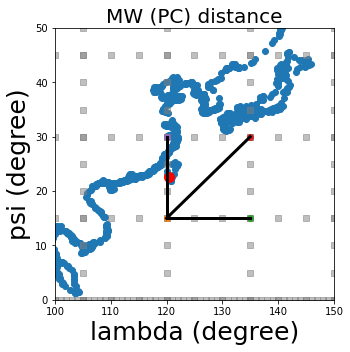

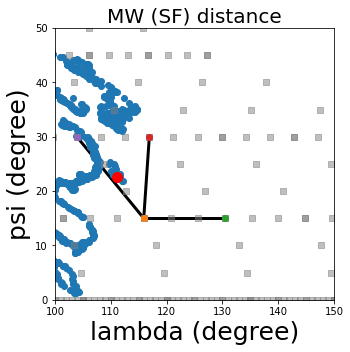

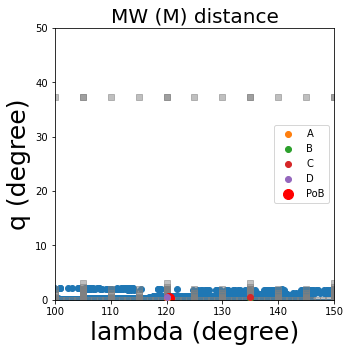

In [205]:
# plot on the maps
ABCD['name']=['A',"B",'C','D']
## plot Plate Carree
# f=plt.figure(figsize=(40,20))
pc=plt.figure(figsize=(5,5))
plt.title('MW (PC) distance',fontsize=20)
plt.xlabel('lambda (degree)',fontsize=25)
plt.xlim(100,150)
plt.ylim(0,50)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['Xm_pc'],coastline['Ym_pc'])
plt.scatter(grid['Xm_pc'],grid['Ym_pc'],marker=',',color='gray',alpha=0.5)
plt.plot([ABCD['lambda'][0],ABCD['lambda'][1]],[ABCD['psi'][0],ABCD['psi'][1]],linewidth=3,color='black',label='')
plt.plot([ABCD['lambda'][0],ABCD['lambda'][3]],[ABCD['psi'][0],ABCD['psi'][3]],linewidth=3,color='black',label='')
plt.plot([ABCD['lambda'][0],ABCD['lambda'][2]],[ABCD['psi'][0],ABCD['psi'][2]],linewidth=3,color='black',label='')

for i in range(4):
    plt.scatter(ABCD['lambda'][i],ABCD['psi'][i],label=ABCD['name'][i])
plt.scatter(poi['lon (deg)'][0],poi['lat (deg)'][0],label='PoB',s=100,color='red')
## plot sf
sf=plt.figure(figsize=(5,5))
plt.title('MW (SF) distance',fontsize=20)
plt.xlabel('lambda (degree)',fontsize=25)
plt.xlim(100,150)
plt.ylim(0,50)
plt.ylabel('psi (degree)',fontsize=25)
plt.scatter(coastline['Xm_sf'],coastline['Ym_sf'])
plt.scatter(grid['Xm_sf'],grid['Ym_sf'],marker=',',color='gray',alpha=0.5)
for i in range(4):
    plt.scatter(ABCD['Xm_sf'][i],ABCD['Ym_sf'][i],label=ABCD['name'][i],zorder=10)
plt.scatter(poi['Xm_sf'][0],poi['Ym_sf'][0],label='PoB',s=100,color='red')
plt.plot([ABCD['Xm_sf'][0],ABCD['Xm_sf'][1]],[ABCD['Ym_sf'][0],ABCD['Ym_sf'][1]],linewidth=3,color='black',label='',zorder=0)
plt.plot([ABCD['Xm_sf'][0],ABCD['Xm_sf'][3]],[ABCD['Ym_sf'][0],ABCD['Ym_sf'][3]],linewidth=3,color='black',label='',zorder=0)
plt.plot([ABCD['Xm_sf'][0],ABCD['Xm_sf'][2]],[ABCD['Ym_sf'][0],ABCD['Ym_sf'][2]],linewidth=3,color='black',label='',zorder=0)

## plot mercator
m=plt.figure(figsize=(5,5))

plt.title('MW (M) distance',fontsize=20)
plt.xlabel('lambda (degree)',fontsize=25)
plt.xlim(100,150)
plt.ylim(0,50)
plt.ylabel('q (degree)',fontsize=25)
plt.scatter(coastline['Xm_m'],coastline['Ym_m'])
plt.scatter(grid['Xm_m'],grid['Ym_m'],marker=',',color='gray',alpha=0.5)
for i in range(4):
    plt.scatter(ABCD['Xm_m'][i],ABCD['Ym_m'][i],label=ABCD['name'][i],zorder=10)
plt.scatter(poi['Xm_m'][0],poi['Ym_m'][0],label='PoB',s=100,color='red')
plt.plot([ABCD['Xm_m'][0],ABCD['Xm_m'][1]],[ABCD['Ym_m'][0],ABCD['Ym_m'][1]],linewidth=3,color='black',label='',zorder=0)
plt.plot([ABCD['Xm_m'][0],ABCD['Xm_m'][3]],[ABCD['Ym_m'][0],ABCD['Ym_m'][3]],linewidth=3,color='black',label='',zorder=0)
plt.plot([ABCD['Xm_m'][0],ABCD['Xm_m'][2]],[ABCD['Ym_m'][0],ABCD['Ym_m'][2]],linewidth=3,color='black',label='',zorder=0)




plt.legend()
plt.show()



## Q5 Generate two tables: one for normal aspects and the other for transverse aspects. Each table must have seven columns: Direction (NS, NE, EW), Scales PC, %, Scales SF, %, Scales M, %. Set your NS scale to 100 %.



In [31]:
print('Normal')
print('%15s'%'direction'+'|'+'%15s'%'Scale PC'+'|'+'%7s'%'%(PC)'+'|'+'%15s'%'Scale SF'+'|'+'%7s'%'%(SF)'+'|'+'%15s'%'Scale M'+'|'+'%7s'%'%(M)')
print('---------------------------------------------------------------------------------------------')
print('%15s'%'NS'+'|'+'     1:%8d'%sAD_pc+'|'+'%7.0f'%100+'|'+'     1:%8d'%sAD_sf+'|'+'%7.0f'%(100)+'|'+'     1:%8d'%sAD_m+'|'+'%5.0f'%(100))
print('%15s'%'EW'+'|'+'     1:%8d'%sAB_pc+'|'+'%7.0f'%(sAB_pc/sAD_pc*100)+'|'+'     1:%8d'%sAB_sf+'|'+'%7.0f'%(sAB_sf/sAD_sf*100)+'|'+'     1:%8d'%sAB_m+'|'+'%5.0f'%(sAB_m/sAD_m*100))
print('%15s'%'NE'+'|'+'     1:%8d'%sAC_pc+'|'+'%7.0f'%(sAC_pc/sAD_pc*100)+'|'+'     1:%8d'%sAC_sf+'|'+'%7.0f'%(sAC_sf/sAD_sf*100)+'|'+'     1:%8d'%sAC_m+'|'+'%5.0f'%(sAC_m/sAD_m*100))
print()
print('Transversed')
print('%15s'%'direction'+'|'+'%15s'%'Scale TPC'+'|'+'%7s'%'%(TPC)'+'|'+'%15s'%'Scale TSF'+'|'+'%7s'%'%(TSF)'+'|'+'%15s'%'Scale TM'+'|'+'%7s'%'%(TM)')
print('---------------------------------------------------------------------------------------------')
print('%15s'%'NS'+'|'+'     1:%8d'%sAD_tpc+'|'+'%7.0f'%100+'|'+'     1:%8d'%sAD_tsf+'|'+'%7.0f'%(100)+'|'+'     1:%8d'%sAD_tm+'|'+'%5.0f'%(100))
print('%15s'%'EW'+'|'+'     1:%8d'%sAB_tpc+'|'+'%7.0f'%(sAB_tpc/sAD_tpc*100)+'|'+'     1:%8d'%sAB_tsf+'|'+'%7.0f'%(sAB_tsf/sAD_tsf*100)+'|'+'     1:%8d'%sAB_tm+'|'+'%5.0f'%(sAB_m/sAD_tm*100))
print('%15s'%'NE'+'|'+'     1:%8d'%sAC_tpc+'|'+'%7.0f'%(sAC_tpc/sAD_tpc*100)+'|'+'     1:%8d'%sAC_tsf+'|'+'%7.0f'%(sAC_tsf/sAD_tsf*100)+'|'+'     1:%8d'%sAC_tm+'|'+'%5.0f'%(sAC_m/sAD_tm*100))


Normal
      direction|       Scale PC|  %(PC)|       Scale SF|  %(SF)|        Scale M|   %(M)
---------------------------------------------------------------------------------------------
             NS|     1:11119492|    100|     1: 8004147|    100|     1:11250252|  100
             EW|     1:10740605|     97|     1:11429913|    143|     1:10740605|   95
             NE|     1:10931690|     98|     1:15299367|    191|     1:10995402|   98

Transversed
      direction|      Scale TPC| %(TPC)|      Scale TSF| %(TSF)|       Scale TM|  %(TM)
---------------------------------------------------------------------------------------------
             NS|     1: 1708296|    100|     1: 2460639|    100|     1: 1546343|  100
             EW|     1:37743571|   2209|     1:37746119|   1534|     1:37699528|  695
             NE|     1:11019197|    645|     1:11393699|    463|     1:10971285|  711
